Team members: 
* Fatou SALL
* Sebastion COUBE




In [158]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Introduction

Le clustering sont des outils d'analyse des données qui permettent de grouper des échantillons, de sorte que les membres d'un même groupe (ou *cluster*) sont très similaires, alors que ceux de groupes différents ne le sont pas. Dans la suite, nous allons préciser explorer Clustering Spectral. 

>-Soit $G = (V,E)$ un graphe non orienté avec $V$ l'ensemble des sommets et $E$ l'ensemble des arrets avec un poid non negative $w_{ij} ≥ 0$.


>-La matrice adjacente du graphe $G$ est la matrice $W = (w_{ij})$ $i,j=1,...,n$.

>-Le degrée d'un sommet $v_i \in V$ est defini par $d_i = \sum\limits_{j=1}^n w_{ij}$.

>-Le degrée matricielle $D$ est défini par une matrice diagonale ayant pour diagonales les degrées $d_1, . . . , d_n$.







In [159]:
import pandas as pd
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import lil_matrix
import seaborn as sns
import networkx as nx
import operator
from networkx.algorithms import community
import plotly
import plotly.graph_objs as go
import plotly.plotly as py

from networkx.drawing.nx_agraph import graphviz_layout
from scipy import linalg, cluster, sparse
from tqdm import tqdm_notebook
from utils import get_bag_of_communities

from utils import load_obj, save_obj

## Algorithme

### Etape 1  : Calcul du laplacien

In [298]:
def diag_matrice_degre(w):
    #print("0-Calcul de la matrice dégré d ..................... ")
    
    return np.diag(np.sum(w,axis=1))


def laplacien(w):
    #print("1-Calcul du laplacien ..................... ")
    return diag_matrice_degre(w)-w   

### Etape 2 : Calcul des k vecteurs associés aux k plus petites valeurs propres du laplacien

In [299]:
def k_vector_propre(L,k): 
    #print("2-Calcul des {} vecteurs associés aux {} plus petites valeurs propres du laplacien ..................... ".format(k,k))
    eigenvalues, eigenvectors = np.linalg.eig(L)
    sorted_index = np.argsort(eigenvalues)
    eigenvectors=np.array(eigenvectors)
    plt.plot(eigenvalues, '.-', markersize=15)
    plt.imshow
    return eigenvectors[:,sorted_index[0:k]]
    


### Etape 3  : Partitionnement des vecteurs propres en avec kmeans

In [302]:
def spectralClustering(w,k):
    #print("3-Partitionnement des vecteurs propres en avec kmeans ..................... ")
    L=laplacien(w)
    Y=k_vector_propre(L,k) 
    return Kmeans(Y,k)
def initialize(X,K):
     #print('Initialisation .....................\n ')
    centers = X[random.sample(range(0,(X.shape[0]-1)),K)]
    return centers

def assignment(X, centers):
    indx = []
    for point in X:
        norm = np.linalg.norm((centers-point), axis =1)
        indx.append(np.argmin(norm))
    return indx

def updateCenters(X,K,indx):

    newCenters = []
    for clusterNumber in range(0,K):
        Cluster = X[[i for i, find in enumerate(indx) if find == clusterNumber]]
        centroid = Cluster.mean(axis=0)
        newCenters.append(centroid)
    return newCenters

def AvgScore(X,K,indx,centers):
    score = []
    for clusterNumber in range(0,K):
        Cluster = X[[i for i, find in enumerate(indx) if find == clusterNumber]]
        distanceList = np.linalg.norm((Cluster-centers[clusterNumber]), axis =1)
        score.append(np.mean(distanceList))
            
    return score



def Kmeans(X,K,tol=0.0001,plot=False,stat=False):
    X = np.array(X)
    centers = initialize(X,K)
    indx = assignment(X, centers)
    AvgScore(X,K,indx,centers)
    Distortion = 1
    #print('Mis à jours des clusters .....................\n ')
    while Distortion > tol:
        newCenters = updateCenters(X,K,indx)
        newIndx = assignment(X, newCenters)
        
        scoreOld = AvgScore(X,K,indx,centers)
        scoreNew = AvgScore(X,K,newIndx,newCenters)
        
        Distortion = np.linalg.norm((np.array(scoreOld) - np.array(scoreNew)), axis =0)
        centers = newCenters
        indx = newIndx
        if stat:
            print('Score Old:',scoreOld,'\n')
            print('Score new:',scoreNew,'\n')
            print('Distortion:', Distortion)
            print('---------------------')
        
    if plot:
        DisplayPlot(X,K,centers,indx)
        
    return centers, indx, scoreNew

In [296]:
def DisplayPlot(X,K,centers,indx):
    colors = ['green', 'purple', 'yellow', 'red', 'orange', 'plum', 'navy', 'seagreen', 'pink', 'brown']
    for clusterNumber in range(0,K):
        Cluster = X[[i for i, find in enumerate(indx) if find == clusterNumber]]
        plt.scatter(Cluster[:,0],Cluster[:,1], marker='.' ,color=colors[clusterNumber])
        plt.scatter(np.array(centers)[clusterNumber,0],np.array(centers)[clusterNumber,1], marker='+' ,color='black')    
    plt.show()

## Application:

### Données simulées

In [164]:

from sklearn import cluster, datasets
noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)
df = pd.DataFrame(noisy_moons[0]) ## convert to DF



#### Génération d'une matrice poids adjacente

In [165]:
def matrice_adjacente(X,gamma):
    n=X.shape[0]
    a=np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            a[i,j] = math.exp(-math.pow(np.linalg.norm((X[i]-X[j]),2),2) * gamma)
    return a
def construct_W(X, Wtemp, k_neighbors):
    scores_matrix = lil_matrix(Wtemp)
    # knn_matrix is a sparse matrix
    knn_matrix = kneighbors_graph(X, k_neighbors, mode='connectivity', include_self=True)
    W = knn_matrix.multiply(scores_matrix)  # pointwise multiply
    return W.toarray()

#### Visualisation des données

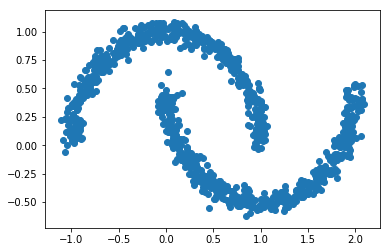

In [279]:


import matplotlib.pyplot as plt
plt.scatter(df[0],df[1])
plt.show()

 #### Détection de communauté:

C:\Anacond\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning:

Casting complex values to real discards the imaginary part



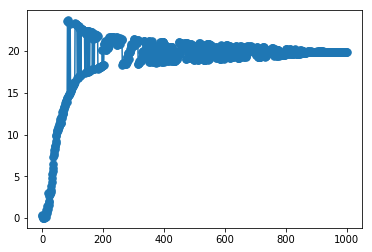

In [303]:
X = np.array(df)
A = adj_generate(X,1)
w = construct_W(X,A,20)
centers_sim, indx_sim, score_sim = spectralClustering(w,2)


#### Visualition des communautés trouvées

C:\Anacond\lib\site-packages\numpy\core\numeric.py:544: ComplexWarning:

Casting complex values to real discards the imaginary part



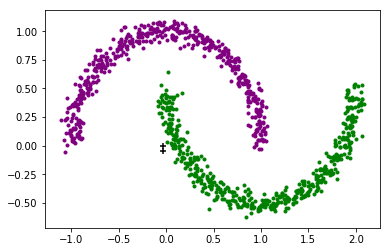

In [280]:
DisplayPlot(np.array(df),2,centers_sim,indx_sim)

### Application sur les données de Wikipedia

#### Parsing des données

In [ ]:
from utils import explore_page

In [ ]:
root_node = 'Jaguar (disambiguation)'

network = {}  # This dict stores for each page a dictionnary containing the keys [url, links, categories]
first_nodes = []

explore_page(root_node, network, first_nodes)

second_nodes = []
for node in first_nodes:
    explore_page(node, network, second_nodes)

In [ ]:
all_nodes = list(network.keys()) + second_nodes
for link in tqdm_notebook(second_nodes):
    explore_page(link, network, [], inner=True, all_nodes=all_nodes)

In [ ]:
all_nodes = list(network.keys())
for title in tqdm_notebook(network.keys()):
    network[title]['links'] = list(set(network[title]['links']).intersection(set(all_nodes)))

In [ ]:


l = list(network.keys())
for i in l:
    if len(network[i]['links']) == 0:
        del network[i]



In [ ]:
for i, title in enumerate(network.keys()):
    cats = network[title]['categories']
    new_cats = []
    for c in cats:
        if not c.startswith('Redundant') and not c.startswith('Pages') and not c.startswith('Webarchive') and not c.startswith('Wikipedia') and not c.startswith('Articles') and not c.startswith('Coordinates on Wikidata') and not 'Wikidata' in c and not c.startswith('CS1') and not c.startswith('EngvarB') and not c.startswith('All') and not c.startswith('Good articles') and not c.startswith('Use dmy'):
            new_cats.append(c)
    network[title]['categories'] = new_cats

#### Création des graphes

In [172]:
# save_obj(network, 'network')
network = load_obj('network')

In [173]:
neighbors = {}
for i in network.keys():
    neighbors[i] = network[i]['links']

In [174]:
g = nx.Graph(neighbors)  # undirected graph

In [175]:
print('Total number of nodes : {}'.format(len(g.nodes)))
print('Total number of edges : {}'.format(len(g.edges)))
if nx.is_connected(g):
    print('The graph is connected.')
else:
    print('The graph is not connected.')

Total number of nodes : 6830
Total number of edges : 367483
The graph is connected.


In [281]:
w = nx.adjacency_matrix(g)
w.shape

(6830, 6830)

In [177]:
def matrice_adjacente(X):
    return nx.adjacency_matrix(X)

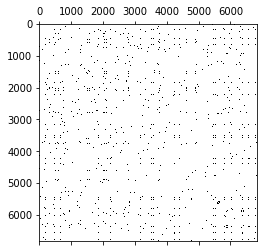

In [282]:

plt.spy(adj.todense())


In [179]:


(adj != adj.T).count_nonzero() == 0



True

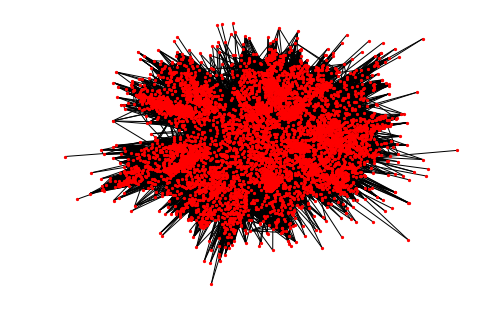

In [188]:
#nx.draw(g, node_size=5, figsize=(15, 15))

#### Détection des communautés

C:\Anacond\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning:

Casting complex values to real discards the imaginary part



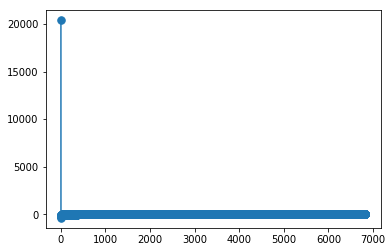

In [304]:
k=2
w = nx.adjacency_matrix(g)
centroid_ , labels, score = spectralClustering(w,k)


In [305]:
def partitions(spectral_partition):
    partition = {}
    for i in range(k):
        comp=[]
        for title,labels in spectral_partition.items():
            if i==labels:
                comp.append(title)   
        partition[i]=set(comp)
    return list(partition.values())

In [306]:
spectral_partition = {}
for i, title in enumerate(network.keys()):
    spectral_partition[title] = labels[i]

In [307]:
spectral_partition = {}
for i, title in enumerate(network.keys()):
    #print(title)
    spectral_partition[title] = labels[i]


In [308]:
spectral_bag = get_bag_of_communities(network, spectral_partition)

In [309]:

spectral_counts = [0 for _ in range(k)]
for i, title in enumerate(spectral_partition.keys()):
    spectral_counts[spectral_partition[title]] += 1



In [312]:
partition=partitions(spectral_partition)
spectral_performance = community.performance(g,partition)

In [313]:
spectral_modularity

0.1801404611759298

In [315]:
spectral_modularity = community.modularity(g,partition)
print(spectral_modularity)
spectral_performance = community.performance(g,partition)
print(spectral_performance)

#### Validation croisée pour le k optimal

In [ ]:
cross_val = {}
for k in tqdm_notebook(range(10, 30)):
    tmp_modularity = []
    tmp_performance= []
    for _ in range(5):
        centroid , labels, score = spectralClustering(w,k)
        spectral_partition = {}
        for i, title in enumerate(network.keys()):
            spectral_partition[title] = labels[i]
        partition=partitions(spectral_partition)
        spectral_modularity = community.modularity(g,partition)
        spectral_performance = community.performance(g,partition)
        tmp_modularity.append(spectral_modularity)
        tmp_performance.append(spectral_modularity)
    cross_val_modularity[k] = [np.mean(tmp_modularity), np.std(tmp_modularity)]
    cross_val_performance[k] = [np.mean(tmp_performance), np.std(tmp_performance)]
    


HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

In [ ]:
save_obj(cross_val_modularity, 'cross_val_modularity')
save_obj(cross_val_performance, 'cross_val_performance')

In [ ]:


cross_val = load_obj('cross_val')
cross_val



In [187]:
G = nx.karate_club_graph()
p = community.best_partition(G, weight='weight')
print(p)

#### Visualition des communautés

In [ ]:
community2color = {
    0: sns.xkcd_rgb["peach"],
    1: sns.xkcd_rgb["powder blue"],
    2: sns.xkcd_rgb["light pink"],
    3: sns.xkcd_rgb["chocolate"],
    4: sns.xkcd_rgb["orange"],
    5: sns.xkcd_rgb["magenta"],
    6: sns.xkcd_rgb["purple"],
    7: sns.xkcd_rgb["blue"],
    8: sns.xkcd_rgb["deep blue"],
    9: sns.xkcd_rgb["sky blue"],
    10: sns.xkcd_rgb["olive"],
    11: sns.xkcd_rgb["seafoam green"],
    12: sns.xkcd_rgb["tan"],
    13: sns.xkcd_rgb["mauve"],
    14: sns.xkcd_rgb["hot pink"],
    15: sns.xkcd_rgb["pale green"],
    16: sns.xkcd_rgb["indigo"],
    17: sns.xkcd_rgb["lavender"],
    18: sns.xkcd_rgb["eggplant"],
    19: sns.xkcd_rgb["brick"],
    20: sns.xkcd_rgb["light blue"],
}

In [ ]:
position = nx.spring_layout(g)

In [ ]:


for community in set(spectral_partition.values()) :
    list_nodes = [nodes for nodes in spectral_partition.keys() if spectral_partition[nodes] == community]
    nx.draw_networkx_nodes(g, position, list_nodes, node_size=20, node_color=community2color[int(community)])

nx.draw_networkx_edges(g, position, alpha=0.5)
plt.show()



In [ ]:
for i in spectral_partition.keys():
    spectral_partition[i] = str(spectral_partition[i])

In [ ]:
nx.set_node_attributes(g, spectral_partition, 'spectral')

In [ ]:
nx.write_graphml(g, 'data/full_graph.graphml')